# Notebook for testing the tuned Direct Yaw Estimator on test turbines

In [1]:
from yaw_estimation import DirectYawEstimator
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import os, sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import seaborn as sns
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
from modules.preprocessing import *
from modules.io import *
from modules.learning import *
from modules.patterns import *
from modules.statistics import *
from modules.plots import *
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from tqdm.notebook import tqdm
import seaborn
import pickle
from copy import deepcopy
from timeit import default_timer as timer
from sklearn.ensemble import RandomForestRegressor as RFRegressor
from lightgbm import LGBMRegressor as lgbmr
import joblib
plt.style.use('ggplot')

# Load Pre-trained Model and scaler
Load the saved model and scaler object that were trained on BBZ1 and BBZ3

In [2]:
scaler_file = 'scaler_1_3.pickle'
models_file = 'yaw_estimator_trained_on_1_3.z' 

with open(models_file, 'rb') as file:
    pipe = joblib.load(file)
    
with open(scaler_file, 'rb') as file:
    scaler = pickle.load(file)

# Test on turbine BEBEZE02
Load data from turbine BEBEZE02 and apply the usual prepreocessing steps for outlier removal, filtering and calculation of dynamic yaw misalignment

Data from turbine 1/BEBEZE02.csv loaded.
Filter Complete
Filter Complete
Filter Complete
Filter Complete
(13977, 212)


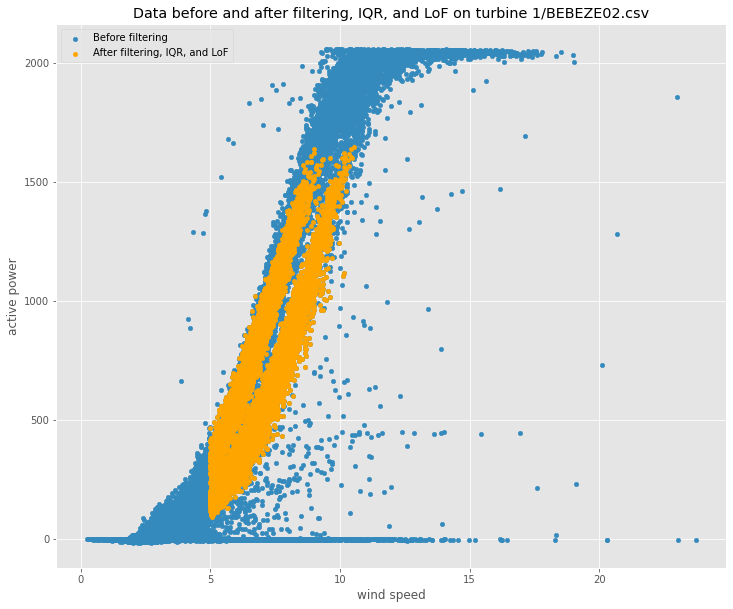

In [3]:
turbines = [f'/data/data2/BBZ_10min_Scada/BEBEZE02.csv']
df_dict = {}

col_names = ['WindSpeed_avg', 'BladeAngle_avg', 'RotorSpeed_avg', 'ActivePower_avg',
             'NacellePosition_avg', 'AbsWindDirection_avg']
            
            
for i, t in enumerate(turbines):
    dataset_file = t
    df_temp = load_df(dataset_file)
    df_temp = df_temp.dropna(axis=1, how='all')
    if len([x for x in df_temp.columns if x in col_names]):
        df_temp = df_temp[col_names + [c for c in df_temp.columns if c not in col_names]]
    df_temp.date = pd.to_datetime(df_temp.date)
    df_temp = df_temp.set_index(df_temp.date)
    df_temp = df_temp.drop(['date'], axis=1)
    cols = ['wind speed', 'pitch angle', 'rotor speed', 'active power',
            'nacelle direction', 'wind direction'] # rename
    
    df_temp.columns = cols + list(df_temp.columns[len(cols):])
    key = f"{i+1}/" + os.path.basename(t)
    df_dict[key] = df_temp
    print(f"Data from turbine {key} loaded.")

granularity = '1min'
for t, df in df_dict.items():
    # Resample with 60second granularity
#     df=change_granularity(df,granularity=granularity)
    # calculate dynamic yaw misalignment and take a 60-min rolling mean
    df["theta_d"] = (df['wind direction'] - df['nacelle direction']) % 360
    df["theta_d"][df["theta_d"] > +180] -= 360
    df["theta_d"][df["theta_d"] < -180] += 360
    df["theta_d"] = df["theta_d"].rolling(6).mean()
    df = df.dropna()

    df_initial = df.copy()

    # Perform IQR outlier removal
    df_iqr = outliers_IQR(df[cols])
    df = df.loc[df_iqr.index]
    # Perform IQR outlier removal on not known columns
    # not_cols = [x for x in df_temp.columns if x not in cols]
    # df_iqr = outliers_IQR(df[not_cols], r=2.5)
    # df = df.loc[df_iqr.index]

    # drop values of wind speed under 5m/s
    df=filter_col(df, 0, less_than=5, bigger_than=11)

    # drop values with pitch angle higher than 2 degrees or lower than -2 degrees
    df=filter_col(df, 1, less_than=-2, bigger_than=2)

    # drop values of rotor speed under 8rpm
    df=filter_col(df, 2, less_than=8, bigger_than=15)

    # drop values of power near the power_limit and near or below zero
    
    power_limit = 2050
    df=filter_col(df, 3, less_than=1e-4, bigger_than= 1 * power_limit)


    # Keep only dates with lidar measurements
    start = '2018-06-02'
    end = '2019-01-11'
    df = filter_dates(df, start, end)
    
    # Remove Outliers using LoF
    # df = outliers_LoF(df).copy()
    
    # Add resulting dataframe to the dict of all dataframes
    print(df.shape)
    df_dict[t] = df
    
    # Uncomment for plots
    ax1=df_initial.plot.scatter(x='wind speed', y='active power', figsize=(12, 10), label='Before filtering')
    df.plot.scatter(ax=ax1, x='wind speed', y='active power', c='orange', label = 'After filtering, IQR, and LoF')
    plt.title(f"Data before and after filtering, IQR, and LoF on turbine {t}")
    plt.show()

# Add yaw labels
Here we load the ground truth yaw misalignment measurements and use them as to annotate our datasets.

Static Yaw angles: [2.7, 2.7, 4.9, 0.0, 0.0]


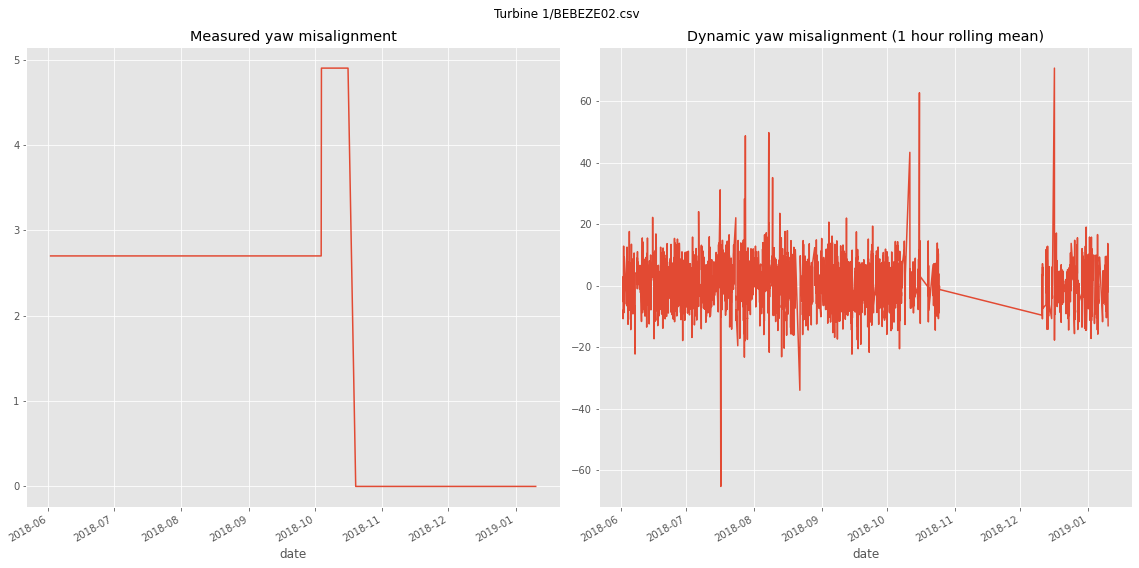

In [4]:
df_labels = pd.read_csv('/data/data2/panos/Yaw.csv')
df_angles_dict = {}
for i, t in enumerate(turbines):
    key = f"{i+1}/" + os.path.basename(t)
    df_turbine = df_dict[key]
    df_turbine["y"] = np.nan
    if t=='/data/data2/BBZ_10min_Scada/BEBEZE02.csv':
        df_l = df_labels[df_labels.Turbines == '/data/data2/engie_initial/post_treated_data/BEZ/BEBEZE02_scada_high_frequency.parquet']
    #df_l = df_labels[df_labels.Turbines == t]
    for start, end, static in zip(df_l.StartDate, df_l.EndDate, df_l.StaticYaw):
        df_turbine.loc[start:end, 'y'] = static
    df_turbine = df_turbine.dropna()
    df_angles_dict[key] = list(df_l.StaticYaw.values)
    df_dict[key] = df_turbine
    print(f"Static Yaw angles: {df_angles_dict[key]}")
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    plt.suptitle(f'Turbine {key}')

    ax1 = df_turbine['y'].plot(ax=axs[0])
    ax1.set_title(f"Measured yaw misalignment")

    ax2 = df_turbine['theta_d'].plot(ax=axs[1])
    ax2.set_title(f"Dynamic yaw misalignment (1 hour rolling mean)")
    plt.tight_layout()
    plt.show()

# Scale dataset features to 0-1 range
We scale the dataset to 0-1 range with minmax scaling and then save the scaler object for later usage.

In [5]:
# Scale the datasets to 0-1 using minmax scaling
df_scaled_dict = {}
scaler = scaler # use scaler from training

test_list = []
for t, df in df_dict.items():
    df_scaled = df.copy()
    df_scaled_dict[t] = df_scaled
    df_scaled[df_scaled.columns] = scaler.transform(df_scaled)
    df_scaled['y'] = np.abs(df_dict[t]['y']) # use the absolute value of the non-scaled df

df = pd.concat([d for _, d in df_scaled_dict.items()])
df = df.sort_index()
df.describe()

,wind speed,pitch angle,rotor speed,active power,nacelle direction,wind direction,AbsWindDirection_max,AbsWindDirection_min,AbsWindDirection_std,ActivePower_max,...,WindSpeed_2_max,WindSpeed_2_min,WindSpeed_2_std,WindSpeed_2_turbInt,WindSpeed_max,WindSpeed_min,WindSpeed_std,WindSpeed_turbInt,theta_d,y
count,11396.000000,11396.000000,11396.000000,11396.000000,11396.000000,11396.000000,11396.000000,11396.000000,11396.000000,11396.000000,...,11396.000000,11396.000000,11396.000000,11396.000000,11396.000000,11396.000000,11396.000000,11396.000000,11396.000000,11396.000000
mean,0.266141,0.013046,0.461808,0.249181,0.600073,0.596778,0.521244,0.570724,0.013887,0.335822,...,0.263079,0.376176,0.250505,0.274399,0.254479,0.385971,0.263675,0.279097,0.453253,2.389988
std,0.194886,0.056302,0.264053,0.182801,0.269193,0.270391,0.312435,0.248410,0.027577,0.249749,...,0.128689,0.113177,0.133037,0.133981,0.134488,0.121795,0.142784,0.140693,0.055427,1.220369
min,0.000000,0.000000,0.000000,-0.005455,0.000556,0.000111,0.000000,0.000000,0.000116,-0.003944,...,0.004594,0.010576,0.003984,0.016834,0.009486,-0.011029,0.008163,0.007173,-0.156418,0.000000
25%,0.106419,0.000000,0.238653,0.105681,0.437901,0.436984,0.184227,0.396113,0.007221,0.145697,...,0.165391,0.298472,0.143426,0.167971,0.150988,0.300245,0.146939,0.166766,0.419427,2.700000
50%,0.228041,0.000000,0.424597,0.195901,0.600356,0.594030,0.577849,0.535379,0.011411,0.258323,...,0.241960,0.366627,0.235060,0.272593,0.232411,0.375000,0.253061,0.279438,0.452755,2.700000
75%,0.390203,0.000000,0.667643,0.348051,0.852697,0.852586,0.744007,0.805520,0.015832,0.454022,...,0.342266,0.446533,0.334661,0.364737,0.336759,0.461091,0.355102,0.375971,0.485072,2.700000
max,0.935811,0.955000,1.000000,0.915139,0.999972,0.999972,1.000000,0.999806,0.835753,0.991334,...,0.990046,0.868390,1.051793,1.066450,0.911462,0.935049,1.061224,1.059474,1.107870,4.900000


# Split dataset into X (features), y(target)
We split the columns following the sklearn format

In [6]:
features = [c for c in df.columns if c != 'y']
target = 'y'
df_unscaled = pd.concat([d for _, d in df_dict.items()])
df_unscaled = df_unscaled.sort_index()

print(df.shape, df_unscaled.shape)

X_test = df[features]
y_test = df[target]
y_test = np.abs(y_test)

(11396, 213) (11396, 213)


# Predict, print metrics and plot results
We make predictions on the test set and print the Mean Absolute Error, Root Mean Square Error and Mean Average Percentage Error. 
Then we plot the results against the ground truth measurements.


In [7]:
prediction = pipe.predict(X_test)
target = y_test

rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
mape = mape1(target.values, prediction.values)
print('TEST SET RESULTS')
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

TEST SET RESULTS
RMSE = 1.5644462611682817
MAE = 1.4162115116673337
MAPE = 0.5925601637139014


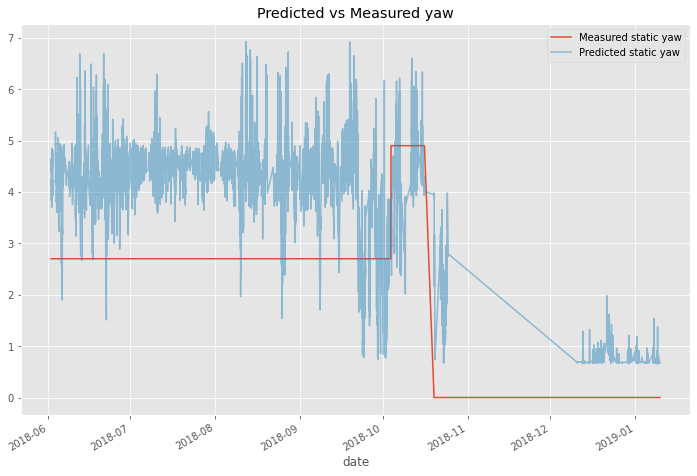

In [8]:
df_plots = pd.DataFrame()
df_plots['y'] = target 
df_plots['y_pred'] = prediction
df_plots['y'].plot(figsize=(12, 8), label = 'Measured static yaw')
df_plots['y_pred'].plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Predicted vs Measured yaw')
plt.legend()
plt.show()

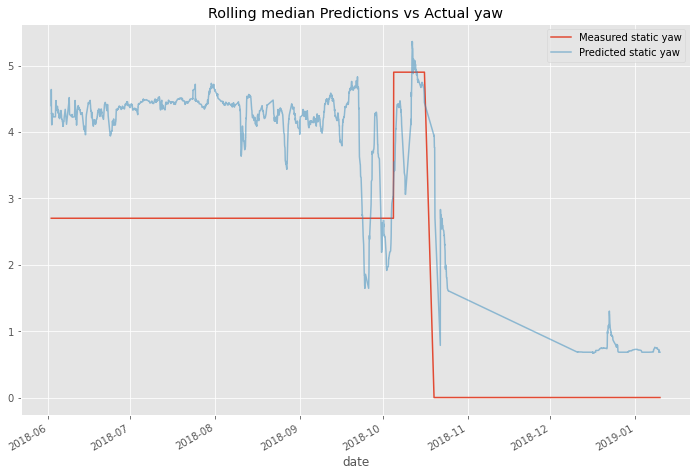

TEST SET RESULTS
RMSE = 1.474430192588188
MAE = 1.3736216946892439
MAPE = 0.5782431147628161


In [9]:
df_plots = pd.DataFrame()
df_plots['y_roll'] = target.rolling('2D').median()
df_plots['y_pred_roll'] = prediction.rolling('2D').median()
df_plots['y_roll'].plot(figsize=(12, 8), label = 'Measured static yaw')
df_plots['y_pred_roll'].plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Rolling median Predictions vs Actual yaw')
plt.legend()
plt.show()
prediction_rolling = df_plots['y_pred_roll']
target_rolling = df_plots['y_roll']
rmse = np.sqrt(np.nanmean((prediction_rolling.values-target_rolling.values)**2))
mae = np.nanmean(np.abs(prediction_rolling.values-target_rolling.values))
mape = mape1(target_rolling.values, prediction_rolling.values)
print('TEST SET RESULTS')
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

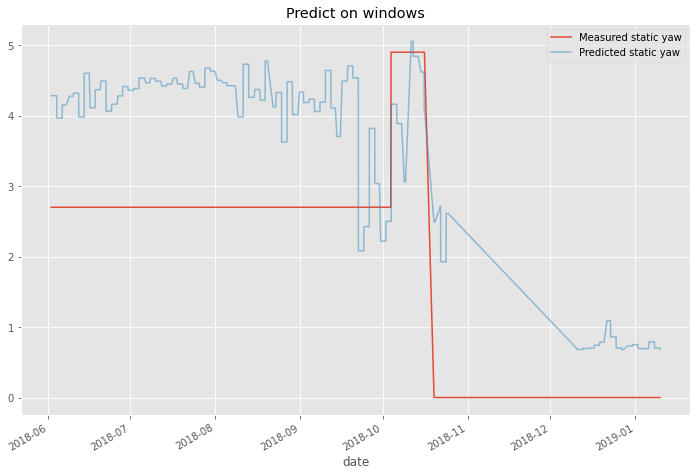

TEST SET RESULTS
RMSE = 1.4581590187075468
MAE = 1.354224531872107
MAPE = 0.5666240555881134


In [10]:
d = 2
df_prediction = pd.DataFrame(np.zeros((X_test.shape[0], 1)), columns=['prediction'], index=X_test.index)
df_target = pd.DataFrame(np.zeros((X_test.shape[0], 1)), columns=['target'], index=X_test.index)
start = X_test.index.min()
end = X_test.index.max()
while end >= start:
    w = start + pd.Timedelta(days=d)
    if len(X_test.loc[start:w]) == 0:
        start = w
        continue
    prediction = pipe.predict(X_test.loc[start:w])
    target = y_test.loc[start:w]
    df_prediction.prediction[start:w] = np.mean(prediction)
    df_target.target[start:w] = np.mean(target)
    start = w
    
df_plots = pd.DataFrame()
df_plots['y'] = y_test
df_plots['y_pred'] = df_prediction.prediction
df_plots['y'].plot(figsize=(12, 8), label = 'Measured static yaw')
df_plots['y_pred'].plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Predict on windows')
plt.legend()
plt.show()

prediction=df_prediction.prediction
target=y_test

rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
mape = mape1(target.values, prediction.values)
print('TEST SET RESULTS')
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

# Test on turbine WAGWR_E04
Load data from turbine WAGWR_E04 and apply the usual prepreocessing steps for outlier removal, filtering and calculation of dynamic yaw misalignment

Data from turbine 1/WAGWR_E04.csv loaded.
Filter Complete
Filter Complete
Filter Complete
Filter Complete
(57668, 212)


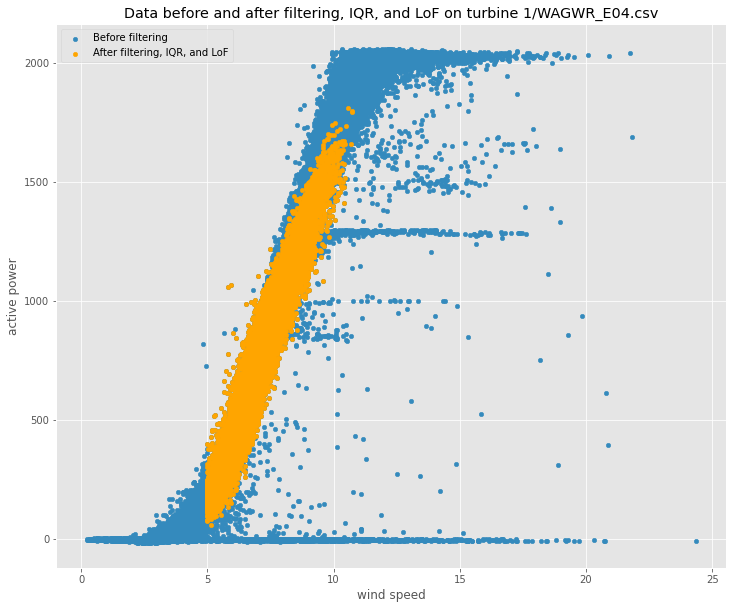

In [11]:
turbines = ['/data/data2/panos/WAGWR_10min_Scada/WAGWR_E04.csv']
df_dict = {}

col_names = ['WindSpeed_avg', 'BladeAngle_avg', 'RotorSpeed_avg', 'ActivePower_avg',
             'NacellePosition_avg', 'AbsWindDirection_avg']
            
            
for i, t in enumerate(turbines):
    dataset_file = t
    df_temp = load_df(dataset_file)
    df_temp = df_temp.dropna(axis=1, how='all')
    if len([x for x in df_temp.columns if x in col_names]):
        df_temp = df_temp[col_names + [c for c in df_temp.columns if c not in col_names]]
    df_temp.date = pd.to_datetime(df_temp.date)
    df_temp = df_temp.set_index(df_temp.date)
    df_temp = df_temp.drop(['date'], axis=1)
    cols = ['wind speed', 'pitch angle', 'rotor speed', 'active power',
            'nacelle direction', 'wind direction'] # rename
    
    df_temp.columns = cols + list(df_temp.columns[len(cols):])
    key = f"{i+1}/" + os.path.basename(t)
    df_dict[key] = df_temp
    print(f"Data from turbine {key} loaded.")

granularity = '1min'
for t, df in df_dict.items():
    # calculate dynamic yaw misalignment and take a 60-min rolling mean
    df["theta_d"] = (df['wind direction'] - df['nacelle direction']) % 360
    df["theta_d"][df["theta_d"] > +180] -= 360
    df["theta_d"][df["theta_d"] < -180] += 360
    df["theta_d"] = df["theta_d"].rolling(6).mean()
    df = df.dropna()

    df_initial = df.copy()

    # Perform IQR outlier removal
    df_iqr = outliers_IQR(df[cols])
    df = df.loc[df_iqr.index]
    # Perform IQR outlier removal on not known columns
    # not_cols = [x for x in df_temp.columns if x not in cols]
    # df_iqr = outliers_IQR(df[not_cols], r=2.5)
    # df = df.loc[df_iqr.index]
    # print('after iqr')
    # print(df.shape)

    # drop values of wind speed under 5m/s
    df=filter_col(df, 0, less_than=5, bigger_than=11)

    # drop values with pitch angle higher than 2 degrees or lower than -2 degrees
    df=filter_col(df, 1, less_than=-2, bigger_than=2)

    # drop values of rotor speed under 8rpm
    df=filter_col(df, 2, less_than=8, bigger_than=15)

    # drop values of power near the power_limit and near or below zero
    
    power_limit = 2050
    df=filter_col(df, 3, less_than=1e-4, bigger_than= 1 * power_limit)

    
    # Remove Outliers using LoF
    # df = outliers_LoF(df).copy()
    
    # Add resulting dataframe to the dict of all dataframes
    print(df.shape)
    df_dict[t] = df
    
    # Uncomment for plots
    ax1=df_initial.plot.scatter(x='wind speed', y='active power', figsize=(12, 10), label='Before filtering')
    df.plot.scatter(ax=ax1, x='wind speed', y='active power', c='orange', label = 'After filtering, IQR, and LoF')
    plt.title(f"Data before and after filtering, IQR, and LoF on turbine {t}")
    plt.show()

# Add yaw labels
Here we load the ground truth yaw misalignment measurements and use them as to annotate our datasets.

Static Yaw angles: [-5.25, 0.0, -10.0, -5.0, -10.0, 0.0]


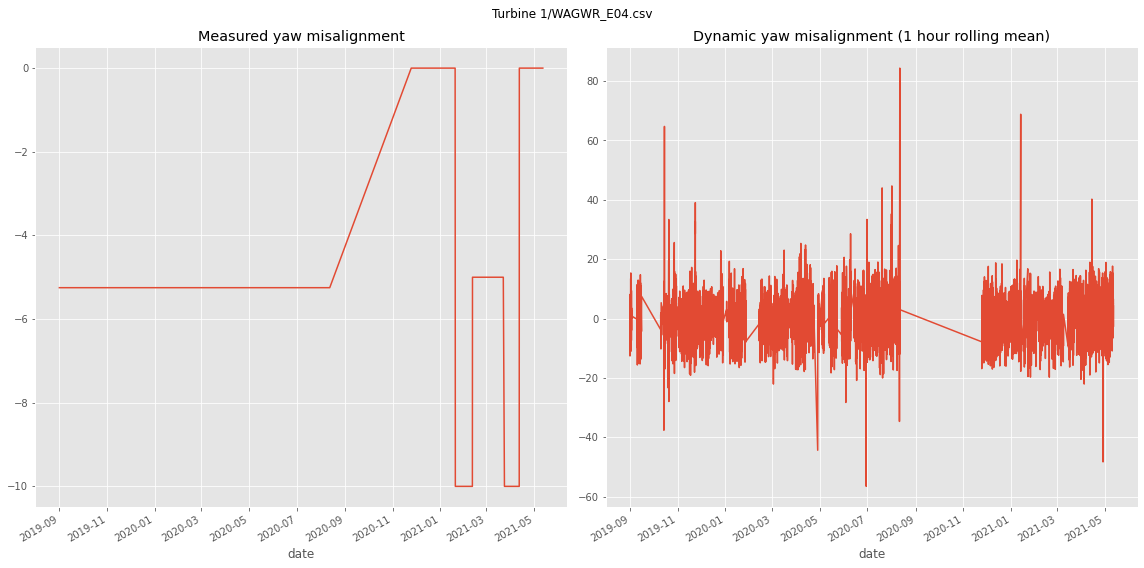

In [12]:
df_labels = pd.read_csv('/data/data2/panos/Yaw.csv')
df_angles_dict = {}
for i, t in enumerate(turbines):
    key = f"{i+1}/" + os.path.basename(t)
    df_turbine = df_dict[key]
    df_turbine["y"] = np.nan
    if t=='/data/data2/panos/WAGWR_10min_Scada/WAGWR_E04.csv':
        df_l = df_labels[df_labels.Turbines == '/data/data2/last_engie_data_formatted/WAGWR/WAGWRWTG04.csv']
    for start, end, static in zip(df_l.StartDate, df_l.EndDate, df_l.StaticYaw):
        df_turbine.loc[start:end, 'y'] = static
    df_turbine = df_turbine.dropna()
    df_angles_dict[key] = list(df_l.StaticYaw.values)
    df_dict[key] = df_turbine
    print(f"Static Yaw angles: {df_angles_dict[key]}")
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    plt.suptitle(f'Turbine {key}')

    ax1 = df_turbine['y'].plot(ax=axs[0])
    ax1.set_title(f"Measured yaw misalignment")

    ax2 = df_turbine['theta_d'].plot(ax=axs[1])
    ax2.set_title(f"Dynamic yaw misalignment (1 hour rolling mean)")
    plt.tight_layout()
    plt.show()

# Scale dataset features to 0-1 range
We scale the dataset to 0-1 range with minmax scaling and then save the scaler object for later usage.

In [13]:
# Scale the datasets to 0-1 using minmax scaling
df_scaled_dict = {}
scaler = scaler # use scaler from training
n_f_in = scaler.n_features_in_

test_list = []
for t, df in df_dict.items():
    actual_columns = list(df.columns)
    df_scaled = df.copy()
    if df_scaled.shape[1] < n_f_in: # workaround for less feats
        df_scaled = pd.concat([df_scaled, pd.DataFrame(np.zeros((df.shape[0], n_f_in - df.shape[1])), index=df.index)], axis=1)
    df_scaled_dict[t] = df_scaled
    df_scaled[df_scaled.columns] = scaler.transform(df_scaled)
    df_scaled.drop(columns=[x for x in df_scaled.columns if x not in actual_columns], inplace=True)
    df_scaled['y'] = np.abs(df_dict[t]['y']) # use the absolute value of the non-scaled df

df = pd.concat([d for _, d in df_scaled_dict.items()])
df = df.sort_index()
df.describe()

,wind speed,pitch angle,rotor speed,active power,nacelle direction,wind direction,AbsWindDirection_max,AbsWindDirection_min,AbsWindDirection_std,ActivePower_max,...,WindSpeed_2_max,WindSpeed_2_min,WindSpeed_2_std,WindSpeed_2_turbInt,WindSpeed_max,WindSpeed_min,WindSpeed_std,WindSpeed_turbInt,theta_d,y
count,29681.000000,29681.000000,29681.000000,29681.000000,29681.000000,29681.000000,29681.000000,29681.000000,29681.000000,29681.000000,...,29681.000000,29681.000000,29681.000000,29681.000000,29681.000000,29681.000000,29681.000000,29681.000000,29681.000000,29681.000000
mean,0.250972,-0.226686,0.588685,0.286553,0.462484,0.462643,0.539224,0.497244,0.018784,0.367384,...,0.281352,0.387063,0.248581,0.268240,0.264564,0.391981,0.255366,0.269400,0.447307,4.685135
std,0.171725,0.089920,0.268243,0.189035,0.260773,0.260003,0.258971,0.273139,0.042150,0.253344,...,0.134050,0.078079,0.128171,0.112215,0.137454,0.082380,0.133845,0.116055,0.054061,2.698362
min,0.000000,-0.245000,-0.008785,-0.026756,-0.000139,0.000083,0.000000,-0.000056,0.000599,-0.007361,...,0.023737,0.011751,0.015936,0.028943,0.011067,-0.009804,0.020408,0.034967,-0.075449,0.000000
25%,0.111486,-0.245000,0.357247,0.128333,0.170450,0.171199,0.275702,0.347872,0.010716,0.162447,...,0.176876,0.333725,0.147410,0.174542,0.158103,0.334559,0.146939,0.170950,0.414690,5.000000
50%,0.224662,-0.245000,0.595900,0.247583,0.515103,0.512570,0.592961,0.492527,0.013303,0.297155,...,0.259571,0.386604,0.227092,0.261075,0.240316,0.390931,0.232653,0.263001,0.447809,5.250000
75%,0.359797,-0.245000,0.828697,0.412873,0.655403,0.654574,0.744604,0.651961,0.016624,0.536730,...,0.363706,0.443008,0.326693,0.343178,0.349407,0.450980,0.334694,0.346981,0.480339,5.250000
max,0.971284,1.000000,1.000000,1.011875,1.000028,0.999944,1.000000,1.000000,1.321099,0.966524,...,0.981623,0.702703,1.211155,1.056409,0.958103,0.709559,1.253061,0.990436,1.235169,10.000000


# Split dataset into X (features), y(target)
We split the columns following the sklearn format

In [14]:
features = [c for c in df.columns if c != 'y']
target = 'y'
df_unscaled = pd.concat([d for _, d in df_dict.items()])
df_unscaled = df_unscaled.sort_index()

print(df.shape, df_unscaled.shape)

X_test = df[features]
y_test = df[target]
y_test = np.abs(y_test)

(29681, 213) (29681, 213)


# Predict, print metrics and plot results
We make predictions on the test set and print the Mean Absolute Error, Root Mean Square Error and Mean Average Percentage Error. 
Then we plot the results against the ground truth measurements.


In [15]:
prediction = pipe.predict(X_test)
target = y_test

rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
mape = mape1(target.values, prediction.values)
print('TEST SET RESULTS')
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

TEST SET RESULTS
RMSE = 4.078623203546702
MAE = 3.279605951977258
MAPE = 0.7000024037238519


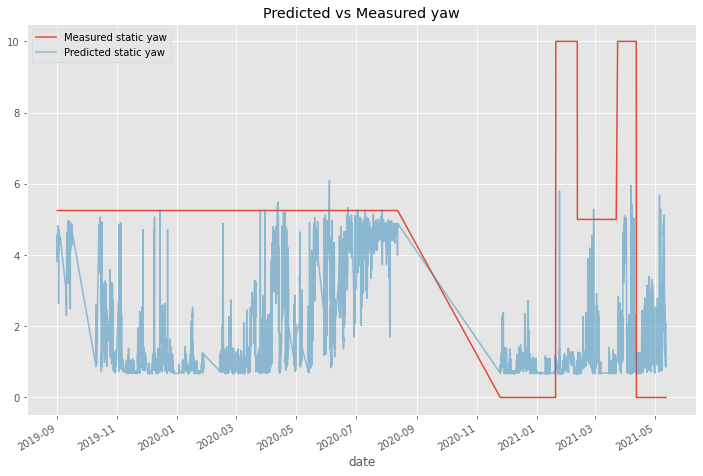

In [16]:
df_plots = pd.DataFrame()
df_plots['y'] = target 
df_plots['y_pred'] = prediction
df_plots['y'].plot(figsize=(12, 8), label = 'Measured static yaw')
df_plots['y_pred'].plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Predicted vs Measured yaw')
plt.legend()
plt.show()

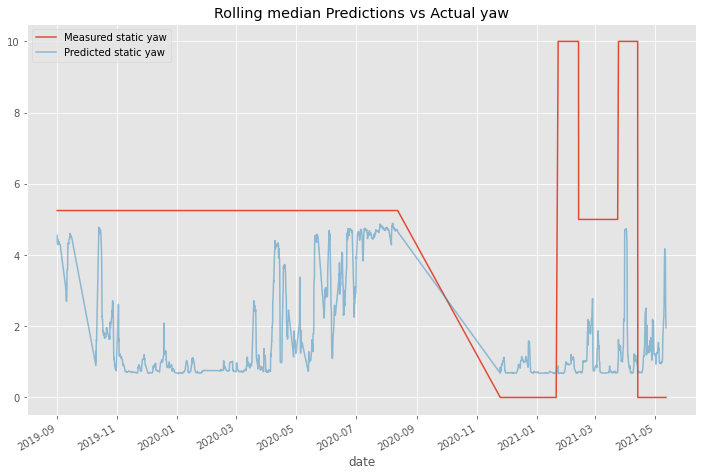

TEST SET RESULTS
RMSE = 4.123576076311309
MAE = 3.3254124075914526
MAPE = 0.7046110649290005


In [17]:
df_plots = pd.DataFrame()
df_plots['y_roll'] = target.rolling('2D').median()
df_plots['y_pred_roll'] = prediction.rolling('2D').median()
df_plots['y_roll'].plot(figsize=(12, 8), label = 'Measured static yaw')
df_plots['y_pred_roll'].plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Rolling median Predictions vs Actual yaw')
plt.legend()
plt.show()
prediction_rolling = df_plots['y_pred_roll']
target_rolling = df_plots['y_roll']
rmse = np.sqrt(np.nanmean((prediction_rolling.values-target_rolling.values)**2))
mae = np.nanmean(np.abs(prediction_rolling.values-target_rolling.values))
mape = mape1(target_rolling.values, prediction_rolling.values)
print('TEST SET RESULTS')
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

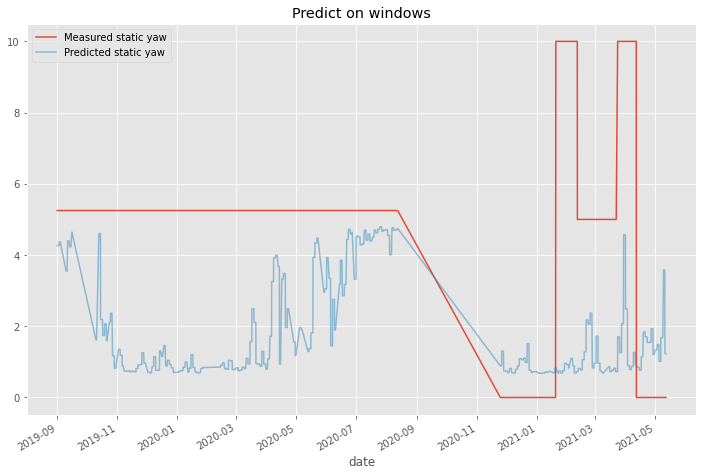

TEST SET RESULTS
RMSE = 4.050188181585911
MAE = 3.279745662476051
MAPE = 0.7000322236736914


In [18]:
d = 2
df_prediction = pd.DataFrame(np.zeros((X_test.shape[0], 1)), columns=['prediction'], index=X_test.index)
df_target = pd.DataFrame(np.zeros((X_test.shape[0], 1)), columns=['target'], index=X_test.index)
start = X_test.index.min()
end = X_test.index.max()
while end >= start:
    w = start + pd.Timedelta(days=d)
    if len(X_test.loc[start:w]) == 0:
        start = w
        continue
    prediction = pipe.predict(X_test.loc[start:w])
    target = y_test.loc[start:w]
    df_prediction.prediction[start:w] = np.mean(prediction)
    df_target.target[start:w] = np.mean(target)
    start = w
    
df_plots = pd.DataFrame()
df_plots['y'] = y_test
df_plots['y_pred'] = df_prediction.prediction
df_plots['y'].plot(figsize=(12, 8), label = 'Measured static yaw')
df_plots['y_pred'].plot(alpha=0.5, label = 'Predicted static yaw')
plt.title('Predict on windows')
plt.legend()
plt.show()

prediction=df_prediction.prediction
target=y_test

rmse = np.sqrt(np.nanmean((prediction.values-target.values)**2))
mae = np.nanmean(np.abs(prediction.values-target.values))
mape = mape1(target.values, prediction.values)
print('TEST SET RESULTS')
print(f"RMSE = {rmse}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")